# FedJAX Intro

[Open In Colab](https://colab.research.google.com/github/google/fedjax/blob/main/notebooks/fedjax_intro.ipynb)

This notebook introduces the basic components of FedJAX and walks through:
* What is federated learning?
* How to run federated simulations.


In [ ]:
!pip install --upgrade -q fedjax==0.0.3

In [ ]:
import collections
import matplotlib.pyplot as plt
import jax
import numpy as np

import fedjax
# We only use TensorFlow for datasets, so we restrict it to CPU only to avoid
# issues with certain ops not being available on GPU/TPU.
fedjax.training.set_tf_cpu_only()

## What is federated learning?

Federated learning (FL) is "a distributed machine learning approach that trains machine learning models using decentralized examples residing on devices such as smartphones."

This means that there are two main actors in FL:
* Server: Centralized server.
* Client: Synonymous with “device”. We use the term “client” from now on.

A typical FL algorithm completes the following steps at each training round:
1. Server selects a subset of Clients to participate in training.
2. Server broadcasts model parameters to the selected Clients.
3. Clients complete training on local data.
4. Clients send model updates to the Server.
5. Server aggregates Client updates into a single update.
6. Server uses this aggregation to update the model.


## How to write and run federated simulations

In this section, we'll describe how to run federated learning simulations. A federated learning simulation typically consists of the following components:
* Federated dataset: a list of client ids and a dataset for each client id.
* Model and parameters
* Optimizers for updating the model parameters
* Federated algorithm: defines how to train across clients and aggregate multiple client outputs into a single server output

We will use the [Federated EMNIST-62](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/emnist/load_data) image recognition task and train our model using the [Federated Averaging](https://arxiv.org/pdf/1602.05629.pdf) algorithm.

### Loading the dataset

For EMNIST, the examples are grouped by writer source where each writer is treated as a separate client. For more details, see https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/emnist/load_data.

FedJAX reuses the already well-defined and supported [`tff.simulation.datasets.ClientData`](https://www.tensorflow.org/federated/api_docs/python/tff/simulation/ClientData) construct introduced by TensorFlow Federated (TFF). There are quite a few functionalities baked in to `tff.simulation.datasets.ClientData`, but for the most part, we only use `client_ids` and `create_tf_dataset_for_client`.

For convenience, we provide `fedjax.datasets.emnist.load_data` as well as other canonical federated datasets under `fedjax.datasets`.

In [ ]:
# Load the train and test federated datasets for MNIST (digits only).
federated_train, federated_test = fedjax.datasets.emnist.load_data(
    only_digits=True)

In [ ]:
# Federated dataset consists of client ids and a dataset for each client id.
# There are 3383 clients in the MNIST federated dataset.
print(f'num_client_ids = {len(federated_train.client_ids)}')

# Let's look at the dataset for one of the clients.
client_id = federated_train.client_ids[0]
client_dataset = federated_train.create_tf_dataset_for_client(client_id)
print(f'client_id = {client_id}')

# client_dataset is a tf.data.Dataset and element_spec just shows up the
# expected structure (name, shape, type) of each element in the dataset.
# In most cases, x is the input and y is the label.
print(f'client_dataset = {client_dataset.element_spec}')

num_client_ids = 3383
client_id = f0000_14
client_dataset = OrderedDict([('x', TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(), dtype=tf.int32, name=None))])


The `client_dataset` almost always contains elements of the following structure

```
{
  'x': features,
  'y': labels
}
```

we refer to this structure as a `Batch`.

The output client dataset is a `tf.data.Dataset` of `tf.Tensor`. However, in order to use these examples with JAX, we'll need to convert this to NumPy arrays. Fortunately, TensorFlow provides `tf.data.Dataset.as_numpy_iterator()` which does exactly what we want and converts a `tf.data.Dataset` to an itertor of NumPy arrays.

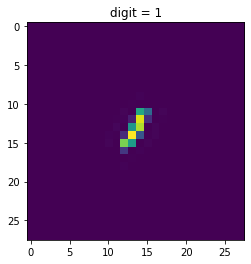

In [ ]:
# We use as_numpy_iterator to convert the tf.data.Dataset to an iterator of
# numpy arrays for use with JAX.
examples = list(client_dataset.as_numpy_iterator())

# For MNIST there are 10 possible labels (digits).
digits = '0123456789'

# x is the pixels for the image and y is the label index.
x = examples[0]['x']
y = examples[0]['y']

# Here, we plot what the input pixels (x) looks like and what the true label is.
plt.title(f'digit = {digits[y]}')
# The pixels are flattened but we reshape back to 2D for viewing.
plt.imshow(x.reshape(28, 28))

### Defining the model

In this section, we will cover how to intialize models suitable for use in FedJAX. Rather than reimplement core model components (layers, etc.), FedJAX uses a flexible structure that is implementation agnostic and works with multiple popular JAX neural network libraries (such as [Haiku](https://github.com/deepmind/dm-haiku) and [stax](https://jax.readthedocs.io/en/latest/jax.experimental.stax.html)).

Similar to datasets, we provide a list of canonical models under `fedjax.models`.

In [ ]:
# Create a multi-layer fully connected neural network for MNIST.
model = fedjax.models.emnist.create_dense_model(
    only_digits=True, hidden_units=100)

Now, we have a common `fedjax.Model` that can work with later FedJAX functions and utilities. This model has a couple of core methods:

* `init_params`: Initializes model parameters.
* `backward_pass`: Returns gradients w.r.t. model parameters as well as a few other outputs such as loss and scalar batch weight (typically batch size).
* `evaluate`: Runs model forward pass and evaluates output predictions.

Because JAX is designed to be functional, there are no stateful functions meaning APIs usually follow the pattern of 

```
# Initialize some state
state = init()
# Take some input state, and return a new, updated output state.
state = apply(state)
```

The same pattern applies for `fedjax.Model` where the input/output is the model parameters (i.e. trainable weights).

In [ ]:
# Initialize model parameters using a pseudo random number generator (PRNG).
# PRNG generated sequences are not truly random but are actually determined by
# an initial value, typically referred to as the `seed`.
# https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html?highlight=random
rng = jax.random.PRNGKey(seed=0)
params = model.init_params(rng)

# View the structure of the parameters.
# jax.tree_util contains functions useful for working with PyTrees
# https://jax.readthedocs.io/en/latest/pytrees.html
print(jax.tree_util.tree_map(lambda l: l.shape, params))

FlatMapping({
  'linear': FlatMapping({'b': (100,), 'w': (784, 100)}),
  'linear_1': FlatMapping({'b': (100,), 'w': (100, 100)}),
  'linear_2': FlatMapping({'b': (10,), 'w': (100, 10)}),
})


Now, we define an example dummy batch input to pass into the model to see what the outputs of `backward_pass` looks like.

In [ ]:
# Example batch input for EMNIST-62 where the leading axis is batch size.
batch_size = 8
example_batch = {
    'x': np.ones((batch_size, 28, 28, 1)),
    'y': np.ones((batch_size))
}

backward_pass_output = model.backward_pass(params, example_batch, rng)
# backward_pass_output contains gradients along with some additional info like
# the number of examples in the input batch.
grads = backward_pass_output.grads
num_examples = backward_pass_output.num_examples

# Note that grads follows the exact same structure of params. This is expected
# since grads is intended to be used to update the weights in params.
print(f'grads structure = {jax.tree_util.tree_map(lambda l: l.shape, grads)}')
# As expected, num_examples is batch_size.
print(f'num_examples = {num_examples}')

grads structure = FlatMapping({
  'linear': FlatMapping({'b': (100,), 'w': (784, 100)}),
  'linear_1': FlatMapping({'b': (100,), 'w': (100, 100)}),
  'linear_2': FlatMapping({'b': (10,), 'w': (100, 10)}),
})
num_examples = 8.0


Now we can use the same example dummy batch input to view the output of `evaluate`.

In [ ]:
# evaluate produces a dictionary of metric names to metric values.
metrics = model.evaluate(params, example_batch)

print('metrics[loss] =', metrics['loss'].result())
print('metrics[accuracy] =', metrics['accuracy'].result())

metrics[loss] = 2.264116
metrics[accuracy] = 0.0


### Optimizers

By default, FedJAX comes packaged with common optimizers like: SGD, Adam, Adagrad, etc. These optimizers are implemented and provided by [optax](https://github.com/deepmind/optax) but we wrap them in a common container (similar to what we do with Model) for use in FedJAX.

Below is an typical example usage of `fedjax.Optimizer`

In [ ]:
optimizer = fedjax.get_optimizer(fedjax.OptimizerName.ADAM, learning_rate=0.1)

# Initialize optimizer state using model parameters
opt_state = optimizer.init_fn(params)
print(f'opt_state = {jax.tree_util.tree_map(lambda l: l.shape, opt_state)}')

# Produce parameter updates using gradients and optimizer state.
updates, opt_state = optimizer.update_fn(grads, opt_state)
print(f'updates = {jax.tree_util.tree_map(lambda l: l.shape, updates)}')

# Apply updates to parameters.
params = optimizer.apply_updates(params, updates)
print(f'params = {jax.tree_util.tree_map(lambda l: l.shape, params)}')

# updates, grads, and params have identical structures but opt_state can contain
# additional statistics that are used in optimizers like Adam.

opt_state = [ScaleByAdamState(count=(), mu=FlatMapping({
  'linear': FlatMapping({'b': (100,), 'w': (784, 100)}),
  'linear_1': FlatMapping({'b': (100,), 'w': (100, 100)}),
  'linear_2': FlatMapping({'b': (10,), 'w': (100, 10)}),
}), nu=FlatMapping({
  'linear': FlatMapping({'b': (100,), 'w': (784, 100)}),
  'linear_1': FlatMapping({'b': (100,), 'w': (100, 100)}),
  'linear_2': FlatMapping({'b': (10,), 'w': (100, 10)}),
})), ScaleState()]
updates = FlatMapping({
  'linear': FlatMapping({'b': (100,), 'w': (784, 100)}),
  'linear_1': FlatMapping({'b': (100,), 'w': (100, 100)}),
  'linear_2': FlatMapping({'b': (10,), 'w': (100, 10)}),
})
params = FlatMapping({
  'linear': FlatMapping({'b': (100,), 'w': (784, 100)}),
  'linear_1': FlatMapping({'b': (100,), 'w': (100, 100)}),
  'linear_2': FlatMapping({'b': (10,), 'w': (100, 10)}),
})


### Federated algorithm

Now that we've defined the federated data and the model, we can move on to actually running the federated algorithm. Almost all federated algorithms consist of two functions.
* `init_state`: Initializes federated algorithm server state
* `run_one_round`: Runs one round of federated training

Below, we'll implement [Federated Averaging (FedAvg)](https://arxiv.org/abs/1602.05629) as these two functions.

In [ ]:
# Setup like initializing our dataset, model, and optimizers.
federated_train, federated_test = fedjax.datasets.emnist.load_data(
    only_digits=True)

model = fedjax.models.emnist.create_dense_model(
    only_digits=True, hidden_units=100)

# client_optimizer used in local client updates is SGD.
client_optimizer = fedjax.get_optimizer(
    fedjax.OptimizerName.SGD, learning_rate=0.1)
# server_optimizer used to update server model parameters from round to round
# is SGD with momentum.
server_optimizer = fedjax.get_optimizer(
    fedjax.OptimizerName.MOMENTUM, learning_rate=1.0, momentum=0.9)

# Generator of PRNGKeys.
rng_seq = fedjax.PRNGSequence(0)

Below is the pseudocode for FedAvg from the original paper:

```
Algorithm 1 FederatedAveraging.
The K clients are indexed by k; B is the local minibatch size,
E is the number of local epochs, and η is the learning rate.

Server executes:
  initialize w_0
  for each round t = 1, 2, . . . do
    m ← max(C · K, 1)
    St ← (random set of m clients)
    for each client k ∈ St in parallel do
      wk_t+1 ← ClientUpdate(k, w_t)
    w_t+1 ← sum_k=1_K((nk/n) * wk_t+1)

ClientUpdate(k, w): // Run on client k
  wk ← w
  B ← (split Pk into batches of size B)
  for each local epoch i from 1 to E do
    for batch b ∈ B do
      wk ← wk − η∇l(wk; b)
  return w - wk to server
```

In [ ]:
# Initialize server state.
FedAvgServerState = collections.namedtuple(
    'FedAvgServerState', ['server_params', 'server_opt_state'])

server_params = model.init_params(next(rng_seq))
server_opt_state = server_optimizer.init_fn(server_params)
server_state = FedAvgServerState(server_params, server_opt_state)


def client_update(server_state, client_data):
  """Updates parameters on local client data."""
  client_params = server_state.server_params
  client_opt_state = client_optimizer.init_fn(client_params)
  num_examples = 0.

  for batch in client_data:
    # Update parameters on mini-batch.
    backward_pass_output = model.backward_pass(
        client_params, batch, next(rng_seq))
    grads = backward_pass_output.grads
    updates, client_opt_state = client_optimizer.update_fn(
        grads, client_opt_state)
    client_params = client_optimizer.apply_updates(client_params, updates)
    # Keep track of total number of examples seen.
    num_examples += backward_pass_output.num_examples

  # Send the model update 
  delta_params = jax.tree_util.tree_multimap(
      lambda a, b: a - b, server_state.server_params, client_params)
  return delta_params, num_examples


def server_update(server_state, client_updates):
  """Updates server state using client updates."""
  # Weighted average of client_updates.
  server_grads = fedjax.tree_mean(client_updates)
  # Update server parameters and optimizer state.
  updates, server_opt_state = server_optimizer.update_fn(
      server_grads, server_state.server_opt_state)
  server_params = server_optimizer.apply_updates(
      server_state.server_params, updates)
  return FedAvgServerState(server_params, server_opt_state)


def evaluate(server_state, client_datas):
  datas = [d for cd in client_datas for d in cd]
  return fedjax.evaluate_single_client(datas, model, server_state.server_params)


# Run multiple federated training rounds.
for round_num in range(10):
  # Sample some subset of clients per training round and read their datasets.
  client_ids = federated_train.client_ids[:3]
  client_datas = []
  for client_id in client_ids:
    tf_dataset = (federated_train.create_tf_dataset_for_client(client_id)
                  .batch(8))
    client_datas.append(list(tf_dataset.as_numpy_iterator()))

  # Run one round of training.
  client_updates = []
  # Run client_update on sampled clients.
  for client_data in client_datas:
    client_updates.append(client_update(server_state, client_data))

  # Update server_state using client_updates.
  server_state = server_update(server_state, client_updates)

  # Run some evaluation to make sure training is happening properly.
  metrics = evaluate(server_state, client_datas)
  print(f'round_num = {round_num}')
  print(f'loss = {metrics["loss"]} accuracy = {metrics["accuracy"]}')

round_num = 0
loss = 2.2629027366638184 accuracy = 0.1345454603433609
round_num = 1
loss = 2.200199604034424 accuracy = 0.10181818157434464
round_num = 2
loss = 2.1171212196350098 accuracy = 0.10545454919338226
round_num = 3
loss = 2.0372910499572754 accuracy = 0.16727273166179657
round_num = 4
loss = 1.5442819595336914 accuracy = 0.4036363661289215
round_num = 5
loss = 1.1109448671340942 accuracy = 0.614545464515686
round_num = 6
loss = 0.7976325154304504 accuracy = 0.7054545283317566
round_num = 7
loss = 0.4819725453853607 accuracy = 0.8472727537155151
round_num = 8
loss = 0.35074591636657715 accuracy = 0.9127272963523865
round_num = 9
loss = 0.36465850472450256 accuracy = 0.9018182158470154


We implemented FedAvg this way in the colab to closely match the pseudocode for clarity and readability. For a faster version, see the implementation inside the library for `fedjax.algorithms.FedAvg`.